In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Add project root to Python path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import *
from src.features import *
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

In [2]:
train_df = load_train_data()
train = train_df.copy()
test_df = load_test_data()
test = test_df.copy()
train = train.drop(columns='id')
test = test.drop(columns='id')

In [3]:
pd.set_option('display.max_columns', None)
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
def resumetable2(df, target_col, missing_value=-1, ignore_cols=None, verbose=True):
    ignore_cols = ignore_cols or []
    if verbose:
        print(f'Data shape: {df.shape}')

    summary = pd.DataFrame(df.dtypes, columns=['Data Type'])
    summary['Missing'] = (df == missing_value).sum().values
    summary['Nunique'] = df.nunique().values
    summary['Feature Type'] = None

    for col in df.columns:
        if 'target' in col:
            summary.loc[col, 'Feature Type'] = 'Target'
        elif 'bin' in col:
            summary.loc[col, 'Feature Type'] = 'Binary'
        elif 'cat' in col:
            summary.loc[col, 'Feature Type'] = 'Categorical'
        else:
            summary.loc[col, 'Feature Type'] = 'Temp'
            
    summary = summary.sort_values(by='Feature Type')
    return summary

In [5]:
feature_table = resumetable2(train, 'target')

Data shape: (595212, 58)


In [6]:
cat_cols = feature_table[feature_table['Feature Type'] == 'Categorical'].index.tolist()
cat_cols = cat_cols + feature_table[feature_table['Feature Type'] == 'Binary'].index.tolist()
cat_cols = cat_cols + feature_table[(feature_table['Nunique'] < 30) & (feature_table['Feature Type'] == 'Temp')].index.tolist()
num_cols = feature_table[(feature_table['Nunique'] >= 30) & (feature_table['Feature Type'] == 'Temp')].index.tolist()

In [7]:
train['target'].value_counts()

target
0    573518
1     21694
Name: count, dtype: int64

1. value_counts: stratified kfold 사용 필요, 타겟값 불균형
2. target 데이터부터 시각화 시작

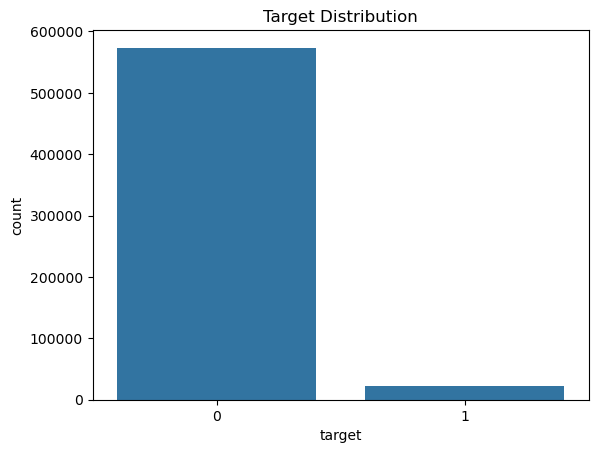

In [8]:
sns.countplot(data=train, x='target')
plt.title('Target Distribution')
plt.show()

In [9]:
from sklearn.metrics import roc_auc_score

def gini_normalized(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

In [10]:
# Pipeline -> Baseline model

# 타겟 정의  
X = train.drop(columns='target')
y = train['target']

# 전처리기 & 피처 생성기 정의 
interaction_fe = InteractionFeatureGenerator()

# 모델 정의 
model = LGBMClassifier(random_state=42)

# 파이프라인 생성 
pipeline = make_pipeline(
    interaction_fe,
    model
)

# 교차 검증 및 평가 
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    pipeline.fit(X_train, y_train)
    
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    score = gini_normalized(y_val.values, y_pred_proba)
    cv_scores.append(score)
    
    print(f'Fold {fold+1} Gini Normalized: {score: .5f}')
    
# 결과
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Baseline CV Score: {mean_cv_score: .5f} +/- {std_cv_score: .5f}')

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 1 Gini Normalized:  0.28310
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 476169, number of

### model.predict_proba()
이진분류에서 predict_proba()는 2차원 배열을 반환 <br>
y_pred_proba = model.predict_proba(X_val)<br>
print(y_pred_proba.shape)  # (n_samples, 2)<br>
print(y_pred_proba[:3])    # 처음 3개 샘플 예시<br>

출력 예시:

[[0.8, 0.2],   첫 번째 샘플: 80% 확률로 class 0, 20% 확률로 class 1 <br>
 [0.3, 0.7],   두 번째 샘플: 30% 확률로 class 0, 70% 확률로 class 1 <br>
 [0.9, 0.1]]   세 번째 샘플: 90% 확률로 class 0, 10% 확률로 class 1 <br>
 

[:, 1]의 의미:<br>
첫 번째 차원(행): 모든 샘플 선택 (:)<br>
두 번째 차원(열): index 1 선택 (1) = class 1의 확률<br>
y_pred_proba[:, 1]  # class 1 확률 (사고 날 확률) <- 우리가 원하는 값

In [18]:
# param_sets = [
#     # Baseline (현재)
#     {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': -1},
    
#     # Set 1: 더 많은 트리, 낮은 학습률
#     {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 64},
    
#     # Set 2: 더 깊은 트리
#     {'n_estimators': 1500, 'learning_rate': 0.03, 'max_depth': 8, 'num_leaves': 100},
    
#     # Set 3: 정규화 강화
#     {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 6, 'num_leaves': 50, 
#      'min_child_samples': 100, 'subsample': 0.8, 'colsample_bytree': 0.8}
# ]

# best_score = 0
# best_params = None

# for i, params in enumerate(param_sets):
#     print(f"\n=== Testing Parameter Set {i+1} ===")
#     print(f"Params: {params}")
    
#     # 모델 생성
#     model = LGBMClassifier(random_state=42, **params)
    
#     # 파이프라인 생성
#     pipeline = make_pipeline(interaction_fe, model)
    
#     # CV 실행
#     cv_scores = []
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#         X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
#         X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
#         pipeline.fit(X_train, y_train)
#         y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
#         score = gini_normalized(y_val.values, y_pred_proba)
#         cv_scores.append(score)
    
#     # 결과 출력
#     mean_score = np.mean(cv_scores)
#     std_score = np.std(cv_scores)
#     print(f"CV Score: {mean_score:.5f} +/- {std_score:.5f}")
    
#     # 최고 점수 업데이트
#     if mean_score > best_score:
#         best_score = mean_score
#         best_params = params
        
# print(f"\n=== BEST RESULT ===")
# print(f"Best Score: {best_score:.5f}")
# print(f"Best Params: {best_params}")



=== Testing Parameter Set 1 ===
Params: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': -1}
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1365
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[Light

### Feature Engineering 

In [12]:
corr_with_target = train.corr()['target'].abs().sort_values(ascending=False)
# .abs(): 절댓값 제시, 타겟 예측에는 절댓값이 중요 
print(corr_with_target.head(15))

target           1.000000
ps_car_13        0.053899
ps_car_12        0.038790
ps_ind_17_bin    0.037053
ps_car_07_cat    0.036395
ps_reg_02        0.034800
ps_ind_07_bin    0.034218
ps_ind_06_bin    0.034017
ps_car_04_cat    0.032900
ps_car_03_cat    0.032401
ps_car_02_cat    0.031534
ps_reg_03        0.030888
ps_ind_05_cat    0.029165
ps_ind_16_bin    0.027778
ps_car_15        0.027667
Name: target, dtype: float64


In [22]:
# 원본으로 초기화
train_data = train.copy()

## Feature Engineering으로 무한 머리박기 
train['high_corr_mult'] = train['ps_car_13'] * train['ps_car_12']

# 타겟 정의  
X = train_data.drop(columns='target')
y = train_data['target']

# 전처리기 & 피처 생성기 정의 
# interaction_fe = InteractionFeatureGenerator()

# 모델 정의 / 머리 박아보면서 feature engineering 검증 -> 파이프라인 없이 과정 최소화하며 바로 검증 
model = LGBMClassifier(random_state=42)

# 교차 검증 및 평가 
N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    score = gini_normalized(y_val.values, y_pred_proba)
    cv_scores.append(score)
    
    print(f'Fold {fold+1} Gini Normalized: {score: .5f}')
    
# 결과
mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Feature Engineered CV Score: {mean_cv_score: .5f} +/- {std_cv_score: .5f}')

[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1883
[LightGBM] [Info] Number of data points in the train set: 476169, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274764
[LightGBM] [Info] Start training from score -3.274764
Fold 1 Gini Normalized:  0.28052
[LightGBM] [Info] Number of positive: 17355, number of negative: 458814
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034597 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1885
[LightGBM] [Info] Number of data points in the train set: 476169, number of

### 분석
1. ps_ind_xx_bin: 거의 대부분의 feature가 의미 적음 


In [15]:
model.fit(X_train, y_train)
gain_importance = model.booster_.feature_importance(importance_type='gain')

feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gain_importance
}).sort_values('importance', ascending=False)

[LightGBM] [Info] Number of positive: 17355, number of negative: 458815
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1367
[LightGBM] [Info] Number of data points in the train set: 476170, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036447 -> initscore=-3.274766
[LightGBM] [Info] Start training from score -3.274766


In [ ]:
feature_importance_df.head(100)

In [ ]:
top_featuers_names = feature_importance_df.head(10)['feature'].tolist()
correlation_matrix = train[top_featuers_names].corr()
correlation_matrix

In [ ]:
# 타겟 변수와의 관계
corr_with_target = train.corr()['target'].abs().sort_values(ascending=False)
# .abs(): 절댓값 제시, 타겟 예측에는 절댓값이 중요 
print(corr_with_target.head(15))